## Group Contributions Statement 

"All three of us wrote the data acquisition and preparation. In Exploratory Analysis part, Youxuan Xu led created and interpreted the summary table. Xinghao Dong created and interpreted the sactter plots. Yixing Fan created and interpreted the box plots and the heat map.
<br>
<br>
In feature selection part, Youxuan Xu raised the idea of using exhaustive search and Xinghao Dong wrote codes for it. Yixing Fan interpreted and explained the results. All three of us made final decisions of choosing features.
<br>
<br>
Youxuan Xu was responsible for the Logistic Regression model, interpreting results, and explaining errors. Xinghao Dong was responsible for the Support Vector Machine model, interpreting results, and explaining errors.
Yixing Fan was responsible for the Random Forest model, interpreting results, and explaining errors.
<br>
<br>
All three of us contributed to writing all other comments, interpretations and explainations.

## Import Needed Modules



In [1]:
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing
import seaborn as sns
url = 'https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv'
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

## Preprocessing Datasets

First step is to read in the penguins dataset,

In [2]:
penguins = pd.read_csv(url)

However, when inspecting the dataset, we found that there was one missing value in the Sex column. The code below can help us to locate the missing value.

In [3]:
penguins[penguins['Sex']=='.']

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
336,PAL0910,117,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N36A1,Yes,12/1/09,44.5,15.7,217.0,4875.0,.,8.04111,-26.18444,NaN


The missing value was found at row 336. Comparing with other Gentoo penguins, we can safely conclude that this missing value should be "FEMALE". Now let's fix it!

In [4]:
penguins.loc[336,'Sex'] = 'FEMALE'

Check if it's correctly fixed...

In [5]:
penguins.loc[336]['Sex']

'FEMALE'

Looks good! Now let's continue to preprocess our data. First by splitting it into train and test datasets.

In [7]:
from sklearn.model_selection import train_test_split
# split X and y into training and test data for test size = 0.2
train, test = train_test_split(penguins, test_size = 0.2)

Notice that there are only a few useful columns. Let's only keep these columns and discard the rest. Also, we need to drop all rows with NaN values, and make the species names shorter.

In [8]:
# Useful columns
cols = ['Species','Island','Culmen Depth (mm)','Culmen Length (mm)',
        'Flipper Length (mm)','Body Mass (g)','Sex']

def prep(datas, columns):
    """
    The function takes in a dataset and a list of desired column names.
    Keep the columns we want and drop the others, drop all rows
    with NaN values, and shorten the species names for our convenience.
    """
    datas = datas[columns]
    datas = datas.dropna()
    datas['Species'] = datas['Species'].str.split().str.get(0)
    return datas


# Preprocess all three datasets we have
train = prep(train, cols)
test = prep(test, cols)
penguins = prep(penguins, cols)

Next, let's encode our qualitative labels with quantative values according to below chart.

 - FEMALE -- 0
   <br>
   MALE -- 1
 - Adelie -- 0 
   <br>
   Chinstrap -- 1 
   <br>
   Gentoo -- 2
 - Biscoe -- 0 
   <br>
   Dream -- 1 
   <br>
   Torgersen -- 2
   <br>

Then split X and y!

In [9]:
def prep_penguins_data(datadata):
    """
    encode the sex, island, and species in penguins as integers
    and split X and y
    """    
    pen = datadata.copy()
    
    # encode the sex, island, and species in penguins as integers 
    le = preprocessing.LabelEncoder()
    le.fit_transform(pen['Sex'])
    pen['Sex'] = le.fit_transform(pen['Sex'])
    
    le2 = preprocessing.LabelEncoder()
    le2.fit_transform(pen['Species'])
    pen['Species'] = le2.fit_transform(pen['Species'])
    
    le3 = preprocessing.LabelEncoder()
    le3.fit_transform(pen['Island'])
    pen['Island'] = le3.fit_transform(pen['Island'])
    
    # split X and y
    X = pen.drop(['Species'], axis = 1)
    y = pen['Species']
    
    return(X, y)

Final step of our data preprocessing! Split the train data and test data into X and y, then check if we get our desired results.

In [10]:
X_train, y_train = prep_penguins_data(train)
X_test, y_test = prep_penguins_data(test)
y_train.shape

(267,)

## Exploratory Analysis

Compute summary statistics and construct visualizations about the relationships between variables.

In [11]:
import seaborn as sns
def penguin_summary_table(group_cols, value_cols):
    """
    This function takes in two lists as inputs. Group
    by the column names in the first list, then return
    the mean values of the columns contained in the 
    second list.
    """
    return(penguins.groupby(group_cols)[value_cols].mean().round(2))

In [15]:
summary = penguin_summary_table(["Species", "Island", "Sex"], 
                                ["Culmen Length (mm)", "Culmen Depth (mm)", 
                                 "Flipper Length (mm)","Body Mass (g)"])
summary

Culmen Length (mm)  Culmen Depth (mm)  \
Species   Island    Sex                                             
Adelie    Biscoe    FEMALE               37.36              17.70   
                    MALE                 40.59              19.04   
          Dream     FEMALE               36.91              17.62   
                    MALE                 40.07              18.84   
          Torgersen FEMALE               37.55              17.55   
                    MALE                 40.59              19.39   
Chinstrap Dream     FEMALE               46.57              17.59   
                    MALE                 51.09              19.25   
Gentoo    Biscoe    FEMALE               45.55              14.26   
                    MALE                 49.47              15.72   

                            Flipper Length (mm)  Body Mass (g)  
Species   Island    Sex                                         
Adelie    Biscoe    FEMALE               187.18        3369.32  
                    MALE                 190.41        4050.00  
          Dream     FEMALE               187.85        3344.44  
                    MALE                 191.93        4045.54  
          Torgersen FEMALE               188.29        3395.83  
                    MALE                 194.91        4034.78  
Chinstrap Dream     FEMALE               191.74        3527.21  
                    MALE                 199.91        3938.97  
Gentoo    Biscoe    FEMALE               212.78        4683.05  
                    MALE                 221.54        5484.84

#### From above summary table,
 - Adelie lives on all three islands. Chinstrap only lives on Dream Island while Gentoo only lives on Biscoe Island.
 - For all three species, male penguins, on average, have longer and deeper culmens, have longer flipper, and weigh more than female penguins.
 - In case of culmen length, Adelie is easily distinguishable because the other two have longer culmens.
 - In case of culmen depth, Gentoo is easily distinguishable because the other two have deeper culmens.
 - In case of flipper length, Gentoo is easily distinguishable because the other two have shorter flippers.
 - In case of body mass, Gentoo is easily distinguishable because the other two weigh less.

<Figure size 720x720 with 0 Axes>

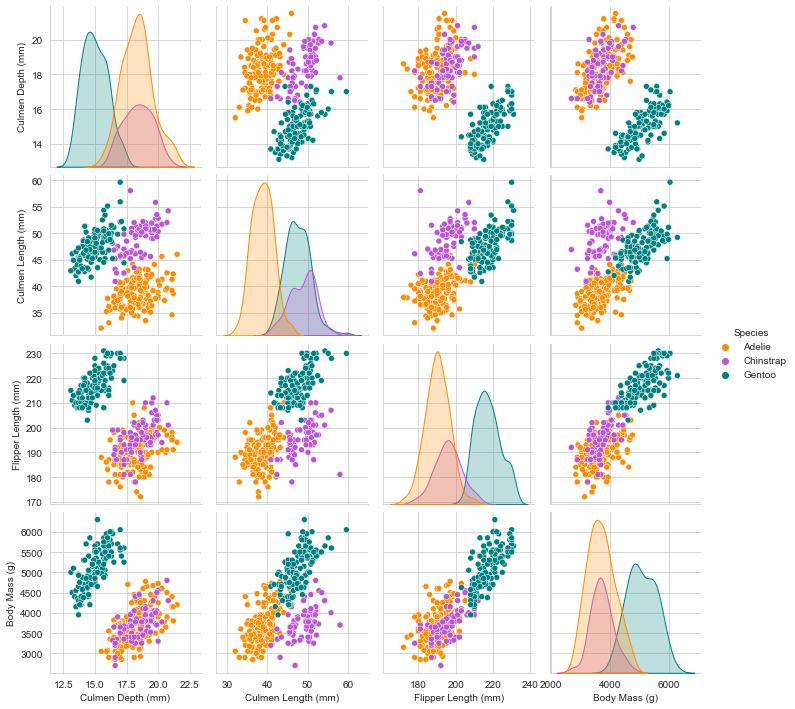

In [16]:
plt.figure(figsize=(10,10))
sns.set_style('whitegrid')
grid1 = sns.pairplot(data = penguins, 
                      hue = 'Species', 
                      palette = ('DarkOrange', 'MediumOrchid', 'Teal'))

#### From above plot we can see that,
 - In case of CUlmen Length, Adelie is easily distinguishable.
 - In case of Culmen Depth, Flipper Length, and Body Mass, Gentoo is easily seperable.

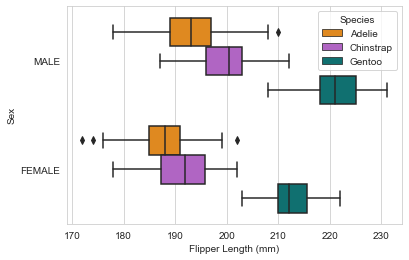

In [17]:
grid2 = sns.boxplot(data = penguins, 
                    x = 'Flipper Length (mm)', 
                    y = 'Sex', hue = 'Species',
                    palette=('DarkOrange', 'MediumOrchid', 'Teal'))

#### From the above plot we can see that,
 - In general, male penguins have longer flippers than female penguins.
 - Gentoo has longer flippers than the other two species.

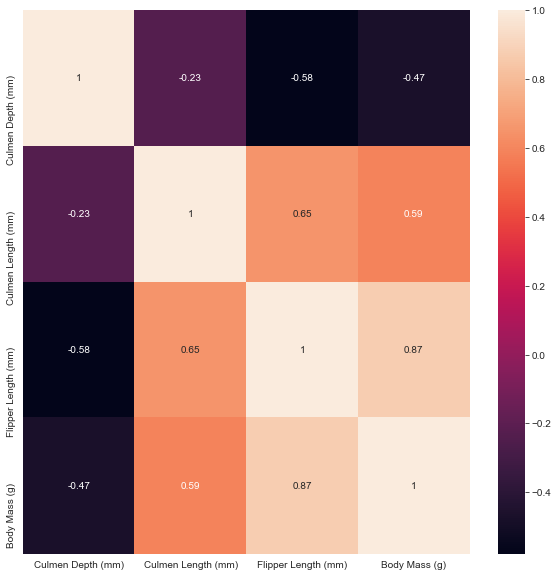

In [18]:
plt.figure(figsize=(10,10))
corr_mat = penguins.corr()
grid3 = sns.heatmap(corr_mat, annot=True)

#### From the above plot we can see that,
 - Flipper length and body mass are strongly dependent with corelation value of 0.87. In other words, penguins with longer flippers generally weigh more.

## Automated Feature Selection
#### Now let's decide what features we want to use in our models. One good way to do it would be list all possible combinations of features and compare their cross validation scores. To achieve this, we can use exhausive search.
### Exhaustive Search

In [19]:
# import useful tools
from itertools import combinations
from sklearn.model_selection import cross_val_score

In [20]:
def exhaustive_search(model, X, y, col_num):
    """
    The function takes in a model, two data sets, and an
    integer indicating desired number of columns. Then 
    return all possible combinations of columns, with their 
    cross-validation scores.
    """
    # initialize two empty lists
    best_cv = []
    best_cols = []
    peng = X.copy()
    # qualitative features list
    X_qualitative = ['Island', 'Sex']
    
    # dataframe with only quantitative features
    X_quantitative = peng.drop(['Island', 'Sex'], axis = 1)
    for cols in combinations(X_quantitative.columns, col_num-1):
        for i in range(0,2):
            colslist = list(cols)
            
            # append one qualitative feature to each combination of
            # quantitative features to make sure we have one qualitative 
            # feature and two quantitative features.
            colslist.append(X_qualitative[i])
            cv = cross_val_score(model, X[colslist], y, cv = 10).mean()
            best_cv.append(cv)
            best_cols.append(colslist)
    
    return best_cv, best_cols

In [21]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver = 'liblinear')

best_cv, best_cols = exhaustive_search(LR, X_train, y_train, 3)
sorted(zip(best_cv, best_cols), reverse=True)[:3]

[(0.9698005698005698, ['Culmen Depth (mm)', 'Culmen Length (mm)', 'Island']),
 (0.9326210826210826, ['Culmen Depth (mm)', 'Culmen Length (mm)', 'Sex']),
 (0.8955840455840456, ['Culmen Length (mm)', 'Body Mass (g)', 'Sex'])]

From above analysis, we can see the three highest cross validation scores and their combinations for our Logistic Regression model. In order to maintain accuracy and diversity at the same time, we decide to choose Sex as our qualitative feature and Culmen Depth & Culmen Length as our quantitative features.

In [22]:
from sklearn import svm
SVM = svm.SVC(gamma = 0.2)

best_cv1, best_cols1 = exhaustive_search(SVM, X_train, y_train, 3)
sorted(zip(best_cv1, best_cols1), reverse=True)[:3]

[(0.9810541310541311, ['Culmen Depth (mm)', 'Culmen Length (mm)', 'Sex']),
 (0.9809116809116809, ['Culmen Depth (mm)', 'Culmen Length (mm)', 'Island']),
 (0.9434472934472934, ['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'])]

From above analysis, we can see the three highest cross validation scores and their combinations for our Support Vector model. In order to maintain accuracy and diversity at the same time, we decide to choose Sex as our qualitative feature and Culmen Depth & Flipper Length as our quantitative features.

In [19]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()

best_cv2, best_cols2 = exhaustive_search(RF, X_train, y_train, 3)
sorted(zip(best_cv2, best_cols2), reverse=True)[:3]

[(0.9887464387464387, ['Culmen Depth (mm)', 'Culmen Length (mm)', 'Sex']),
 (0.9777777777777779, ['Culmen Length (mm)', 'Flipper Length (mm)', 'Island']),
 (0.9773504273504272, ['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'])]

From above analysis, we can see the three highest cross validation scores and their combinations for our Random Forest model. In order to maintain accuracy and diversity at the same time, we decide to choose Sex as our qualitative feature and Culmen Depth & Culmen Length as our quantitative features.

## Model 1: Logistic Regression

Finally! It's time for our models. First, we want to write a function to plot decision regions, so we can easily call the function to plot decision regions for each of our models.

In [12]:
def plot_regions(c, X, y, col1,col2, title):
    """
    The function takes in a classification model c, two datasets X and y,
    two quantatitive column names col1 and cols which will be used as our
    x and y labels, and one qualitative column name which will serve as
    a catagorical variable. Then it plots decision regions for the model.
    """
        
        
    # for convenience, give names to the two 
    # columns of the data
    x0 = X[col1]
    x1 = X[col2]
    c.fit(X,y)
    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    # extract model predictions, using the 
    # np.c_ attribute to join together the 
    # two parts of the grid. 
    # array.ravel() converts an multidimensional
    # array into a 1d array, and we use array.reshape()
    # to turn the resulting predictions p 
    # back into 2d
    
    XX = xx.ravel()
    YY = yy.ravel()
    XY = pd.DataFrame({
        col1 : XX,
        col2  : YY
    })
    
    p = c.predict(XY)
    p = p.reshape(xx.shape)
    
    # create the plot
    fig, ax = plt.subplots(1)
    
    # use contour plot to visualize the predictions
    ax.contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
    
    # plot the data
    ax.scatter(x0, x1, c = y, cmap = "jet", vmin = 0, vmax = 2)
    
    ax.set(xlabel = col1, 
           ylabel = col2,
          title = title)

Now that we have our plot_regions function, we can continue to our models. Let's take some further look into our data first.

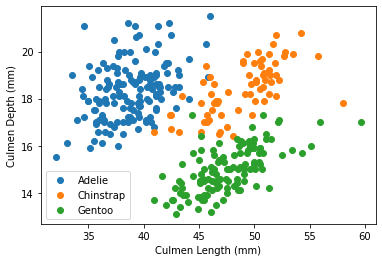

In [13]:
#data analysis
fig, ax = plt.subplots(1)

for s in penguins['Species'].unique():
    df = penguins[penguins['Species'] == s]
    ax.scatter(df['Culmen Length (mm)'], df['Culmen Depth (mm)'], label = s)
ax.set(xlabel = 'Culmen Length (mm)',
       ylabel = 'Culmen Depth (mm)')
ax.legend()

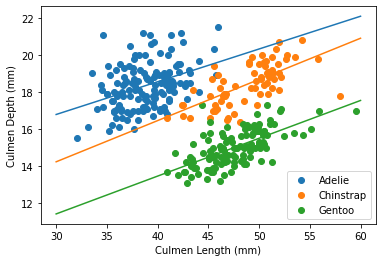

In [14]:
#showing culmen length-culmen depth relationship in different species.
def f(X, a, b): 
    return a*X + b
def linear_MSE(X, Y, a, b):
    preds = f(X, a, b)
    return ((Y - preds)**2).mean()

fig2,ax2=plt.subplots(1)
x=np.linspace(30,60,10000)
#find a linear regression of culmen length-culmen depth relationship in different species.
for s in penguins['Species'].unique():
    df = penguins[penguins['Species'] == s]
    X=df['Culmen Length (mm)']
    Y=df['Culmen Depth (mm)']
    res = minimize(lambda z: linear_MSE(X, Y, z[0], z[1]), np.array([0,0]))
    best_a, best_b = res.x
    
    ax2.scatter(X,Y, label = s)
    ax2.plot(x,f(x,best_a,best_b))

ax2.set(xlabel = 'Culmen Length (mm)',
       ylabel = 'Culmen Depth (mm)')
ax2.legend()

From figures above we can see that the relationship between culmen length and culmen depth differs between species, and is not strictly linear. So we decide to apply a logistic regression model. Feature slection was already discussed above.

In [15]:
#pick appropriate columns
combo=['Sex','Culmen Length (mm)','Culmen Depth (mm)'] 
X_train1=X_train[combo]
X_test1=X_test[combo]

Now let's actually create the model!

In [17]:
m = LogisticRegression(solver = 'liblinear')
cross_val_score(m, X_train1, y_train, cv = 3).mean()

0.9250936329588014

In [18]:
m.fit(X_train1, y_train)
m.score(X_test1, y_test)

0.9701492537313433

The resulting reading, 0.97, means that the model correctly predicted the survival of 97% of the test set. Not bad for our first model!
<br>
Now let's introduce a confusion matrix to our model and see where it's making mistakes.

In [19]:
#confusion matrix
y_test_pred = m.predict(X_test1) 
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, y_test_pred) 
c

array([[32,  1,  0],
       [ 0, 15,  1],
       [ 0,  0, 18]])

In [20]:
table_of_error = X_test1[y_test_pred != y_test][combo]
table_of_error["True Value of Species"] = y_test[y_test_pred != y_test]
table_of_error["Predicted Values of Species"] = y_test_pred[y_test_pred != y_test]
table_of_error

,Sex,Culmen Length (mm),Culmen Depth (mm),True Value of Species,Predicted Values of Species
30,0,39.5,16.7,0,1
165,1,52.0,18.1,1,2


We can see clearly that where our model makes two incorrect predictions:
 - Incorrectly predict a female Adelie penguin with 39.5 mm long and 16.7 mm deep culmen as a Chinstrap. This might because this Adelie has a culmen which is longer than species' average.
 - Incorrectly predict a male Chinstrap penguin with 52 mm long and 18.1 mm deep culmen as a Gentoo. This might because this Chinstrap has a culmen which is longer than species' average.
<br>
Now let's plot decision regions to further look into our errors.

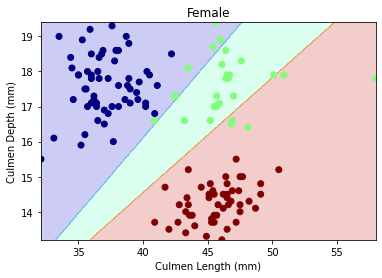

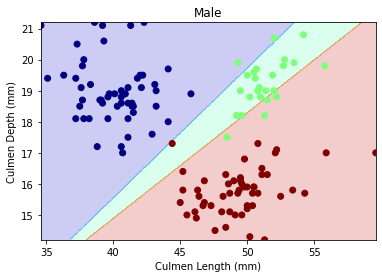

In [22]:
Sexs=['Female','Male']
for i in range(1,3):
    plot_regions(m,X_train1[X_train1['Sex']==i].drop(['Sex'],axis=1),
             y_train[X_train1['Sex']==i],'Culmen Length (mm)','Culmen Depth (mm)',Sexs[i-1])

From above graphs, we can see that our model makes most of its mistakes when predicting Chinstrap penguins. This might because Chinstrap penguins share similar average culmen depth with Adelie while share similar average culmen length with Gentoo penguins. Thus it has overlaps with both of the two other species, making it hard for our model to predict. 

## Model 2: SVM

Now we want to choose a different combination of features. First we need to show which model is the best fit. Let's start by analyzing and visualizing the data.

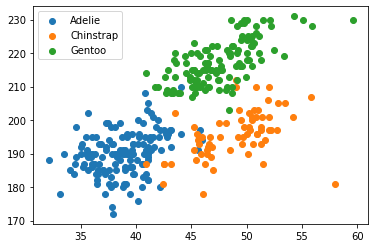

In [23]:
#data analysis
fig, ax = plt.subplots(1)

for s in penguins['Species'].unique():
    df = penguins[penguins['Species'] == s]
    ax.scatter(df['Culmen Length (mm)'], df['Flipper Length (mm)'], label = s)

ax.legend()

From figure above, points cluster based on species and only a few of them overlap. Then we do not need horizontal and vertical boundary to fit the data. So we pick SVM as our model.

In [24]:
from sklearn import svm
SVM = svm.SVC(gamma = 0.2)
combo=['Sex','Culmen Length (mm)','Flipper Length (mm)'] 
X_train1=X_train[combo]
X_test1=X_test[combo]
cross_val_score(SVM, X_train1, y_train, cv = 3).mean()

0.947565543071161

In [25]:
SVM.fit(X_train1, y_train)
SVM.score(X_test1, y_test)

0.9104477611940298

The resulting reading, 0.91, means that the model correctly predicted the survival of 91% of the test set. Still a great score!
<br>
Now let's introduce a confusion matrix to our model and see where it's making mistakes.

In [26]:
#confusion matrix
y_test_pred = SVM.predict(X_test1) 
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, y_test_pred) 
c

array([[31,  2,  0],
       [ 1, 13,  2],
       [ 0,  1, 17]])

In [27]:
table_of_error = X_test1[y_test_pred != y_test][combo]
table_of_error["True Value of Species"] = y_test[y_test_pred != y_test]
table_of_error["Predicted Values of Species"] = y_test_pred[y_test_pred != y_test]
table_of_error

,Sex,Culmen Length (mm),Flipper Length (mm),True Value of Species,Predicted Values of Species
318,0,48.4,203.0,2,1
199,1,49.0,212.0,1,2
192,1,49.0,210.0,1,2
157,0,45.2,198.0,1,0
19,1,46.0,194.0,0,1
111,1,45.6,191.0,0,1


Since the score for SVM is lower than Logistic Regression model, we can see the model is making more mistakes when predicting test data. Four mistakes are shown in the chart above:
 - Incorrectly predict a female Gentoo penguin with 48.4 mm long culmen and 203 mm long flipper as a Chinstrap. This might because this Gentoo has a flipper which is shorter than species' average.
 - Incorrectly predict a male Chinstrap penguin with 49 mm long culmen and 212 mm long flipper as a Gentoo. This might because this Chinstrap has a flipper which is longer than species' average.
 - Incorrectly predict a male Chinstrap penguin with 49 mm long culmen and 212 mm long flipper as a Gentoo. This might because this Chinstrap has a flipper which is longer than species' average.
 - Incorrectly predict a female Chinstrap penguin with 45.2 mm long culmen and 198 mm long flipper as a Adelie. We could not find an appropriate reason for this mistake.
 - Incorrectly predict a male Adelie penguin with 46 mm long culmen and 194 mm long flipper as a Chinstrap. This might because this Adelie has a culmen which is longer than species' average.
 - Incorrectly predict a male Adelie penguin with 45.6 mm long culmen and 191 mm long flipper as a Chinstrap. This might because this Adelie has a culmen which is longer than species' average.

Continue to our decision regions to visualize the errors.

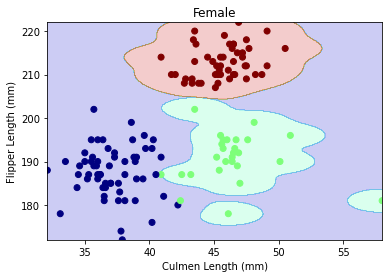

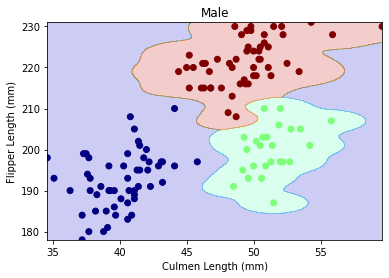

In [28]:
Sexs=['Female','Male']
for i in range(1,3):
    plot_regions(SVM,X_train1[X_train1['Sex']==i].drop(['Sex'],axis=1),
                  y_train[X_train1['Sex']==i],'Culmen Length (mm)','Flipper Length (mm)',Sexs[i-1])

Since we pick gamma to be a small mumber, the model actually miss-interprets some points that overlap.

# Model 3: Random Forest

In the end, we want to do a Random Forest model with Sex as our qualitative feature and Culmen Depth & Culmen Length as our quantatitive features.

In [29]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
combo=['Sex','Culmen Depth (mm)', 'Culmen Length (mm)'] 
X_train1=X_train[combo]
X_test1=X_test[combo]
cross_val_score(RF, X_train1, y_train, cv = 3).mean()

0.9737827715355806

In [30]:
RF.fit(X_train1, y_train)
RF.score(X_test1, y_test)

0.9253731343283582

The resulting reading, 0.925, means that the model correctly predicted the survival of 92.5% of the test set. Pretty nice! 
<br>
Now let's introduce a confusion matrix to our model and see where it's making mistakes.

In [31]:
#confusion matrix
y_test_pred = RF.predict(X_test1) 
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, y_test_pred) 
c

array([[28,  5,  0],
       [ 0, 16,  0],
       [ 0,  0, 18]])

In [32]:
table_of_error = X_test1[y_test_pred != y_test][combo]
table_of_error["True Value of Species"] = y_test[y_test_pred != y_test]
table_of_error["Predicted Values of Species"] = y_test_pred[y_test_pred != y_test]
table_of_error

,Sex,Culmen Depth (mm),Culmen Length (mm),True Value of Species,Predicted Values of Species
17,1,20.7,42.5,0,1
115,1,18.3,42.7,0,1
75,1,18.5,42.8,0,1
19,1,21.5,46.0,0,1
111,1,20.3,45.6,0,1


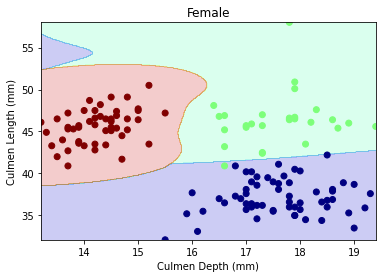

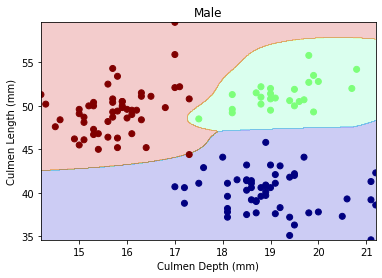

In [33]:
for i in range(1,3):
    plot_regions(SVM,X_train1[X_train1['Sex']==i].drop(['Sex'],axis=1),
             y_train[X_train1['Sex']==i],'Culmen Depth (mm)', 'Culmen Length (mm)',Sexs[i-1])

From above chart and two decision region plots, we can see our model makes most of its mistakes when predicting Adelie penguins.